In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

df = pd.read_csv(r'C:\Users\hmadarw\Learnings\DataScience\Projects\CustomerChurn\churn.csv')

In [50]:
print("PHASE 1: DATA STRUCTURE & QUALITY ASSESSMENT")

PHASE 1: DATA STRUCTURE & QUALITY ASSESSMENT


In [13]:
# 1.1 Shape and basic info
print(f" Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

 Dataset Shape: 10,000 rows × 14 columns
Memory Usage: 2.64 MB


In [16]:
# 1.2 Column types and info
dtype_summary = pd.DataFrame({
    'Column': df.columns,
    'Dtype': df.dtypes.values,
    'Non-Null': df.count().values,
    'Null': df.isnull().sum().values,
    'Null%': (df.isnull().sum() / len(df) * 100).round(2).values,
    'Unique': df.nunique().values
})
print(dtype_summary.to_string(index=False))

         Column   Dtype  Non-Null  Null  Null%  Unique
      RowNumber   int64     10000     0    0.0   10000
     CustomerId   int64     10000     0    0.0   10000
        Surname  object     10000     0    0.0    2932
    CreditScore   int64     10000     0    0.0     460
      Geography  object     10000     0    0.0       3
         Gender  object     10000     0    0.0       2
            Age   int64     10000     0    0.0      70
         Tenure   int64     10000     0    0.0      11
        Balance float64     10000     0    0.0    6382
  NumOfProducts   int64     10000     0    0.0       4
      HasCrCard   int64     10000     0    0.0       2
 IsActiveMember   int64     10000     0    0.0       2
EstimatedSalary float64     10000     0    0.0    9999
         Exited   int64     10000     0    0.0       2


In [17]:
# 1.3 Identify column types for analysis
id_cols = ['RowNumber', 'CustomerId', 'Surname']  # Drop for modeling
target_col = 'Exited'
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'NumOfProducts']
categorical_cols = ['Geography', 'Gender']
binary_cols = ['HasCrCard', 'IsActiveMember']

In [27]:
# 1.4 Target distribution (critical for classification)
target_dist = df[target_col].value_counts()
target_pct = df[target_col].value_counts(normalize=True) * 100
print(f"  Retained (0): {target_dist[0]:,} ({target_pct[0]:.1f}%)")
print(f"  Churned (1):  {target_dist[1]:,} ({target_pct[1]:.1f}%)")
print(f"  Imbalance Ratio: {target_dist[0]/target_dist[1]:.2f}:1")

  Retained (0): 7,963 (79.6%)
  Churned (1):  2,037 (20.4%)
  Imbalance Ratio: 3.91:1


In [38]:
# 1.6 Check for duplicates
dup_count = df.duplicated().sum()
dup_by_customer = df.duplicated(subset=['CustomerId']).sum()
print(f"  Exact row duplicates: {dup_count}")
print(f"  Duplicate CustomerIds: {dup_by_customer}")

  Exact row duplicates: 0
  Duplicate CustomerIds: 0


In [ ]:
# 1.7 Zero/Special value analysis
for col in numerical_cols:
    zero_count= (df[col]==0).sum()
    if zero_count >0:
        zero_pct = zero_count/len(df) * 100
        print(f"  {col}: {zero_count:,} zeros ({zero_pct:.1f}%)")

  Tenure: 413 zeros (4.1%)
  Balance: 3,617 zeros (36.2%)


In [46]:
# 1.8 Categorical value distributions
for col in categorical_cols+binary_cols:
    print(col)
    value_counts = df[col].value_counts()
    for value, counts in value_counts.items():
        pct = counts/len(df) * 100
        print(f"    {value}: {counts:,} ({pct:.1f}%)")

Geography
    France: 5,014 (50.1%)
    Germany: 2,509 (25.1%)
    Spain: 2,477 (24.8%)
Gender
    Male: 5,457 (54.6%)
    Female: 4,543 (45.4%)
HasCrCard
    1: 7,055 (70.5%)
    0: 2,945 (29.4%)
IsActiveMember
    1: 5,151 (51.5%)
    0: 4,849 (48.5%)


Key Insights from Phase 1:

1. No nulls - clean dataset (unusual for real-world, likely preprocessed)
2. ~20% churn rate - moderate imbalance (3.9:1), manageable with class weights or SMOTE
3. 36% have zero balance - significant segment, likely different product type or dormant accounts
4. Age is right-skewed (skew=1.01) - might benefit from binning or log transform
5. Balance is bimodal (zero vs. non-zero) - strong candidate for binary feature engineering
6. NumOfProducts caps at 4 - low cardinality, treat as ordinal or categorical

In [51]:
print("PHASE 2: UNIVARIATE ANALYSIS")

PHASE 2: UNIVARIATE ANALYSIS


In [62]:
axes[1]

<Axes: >

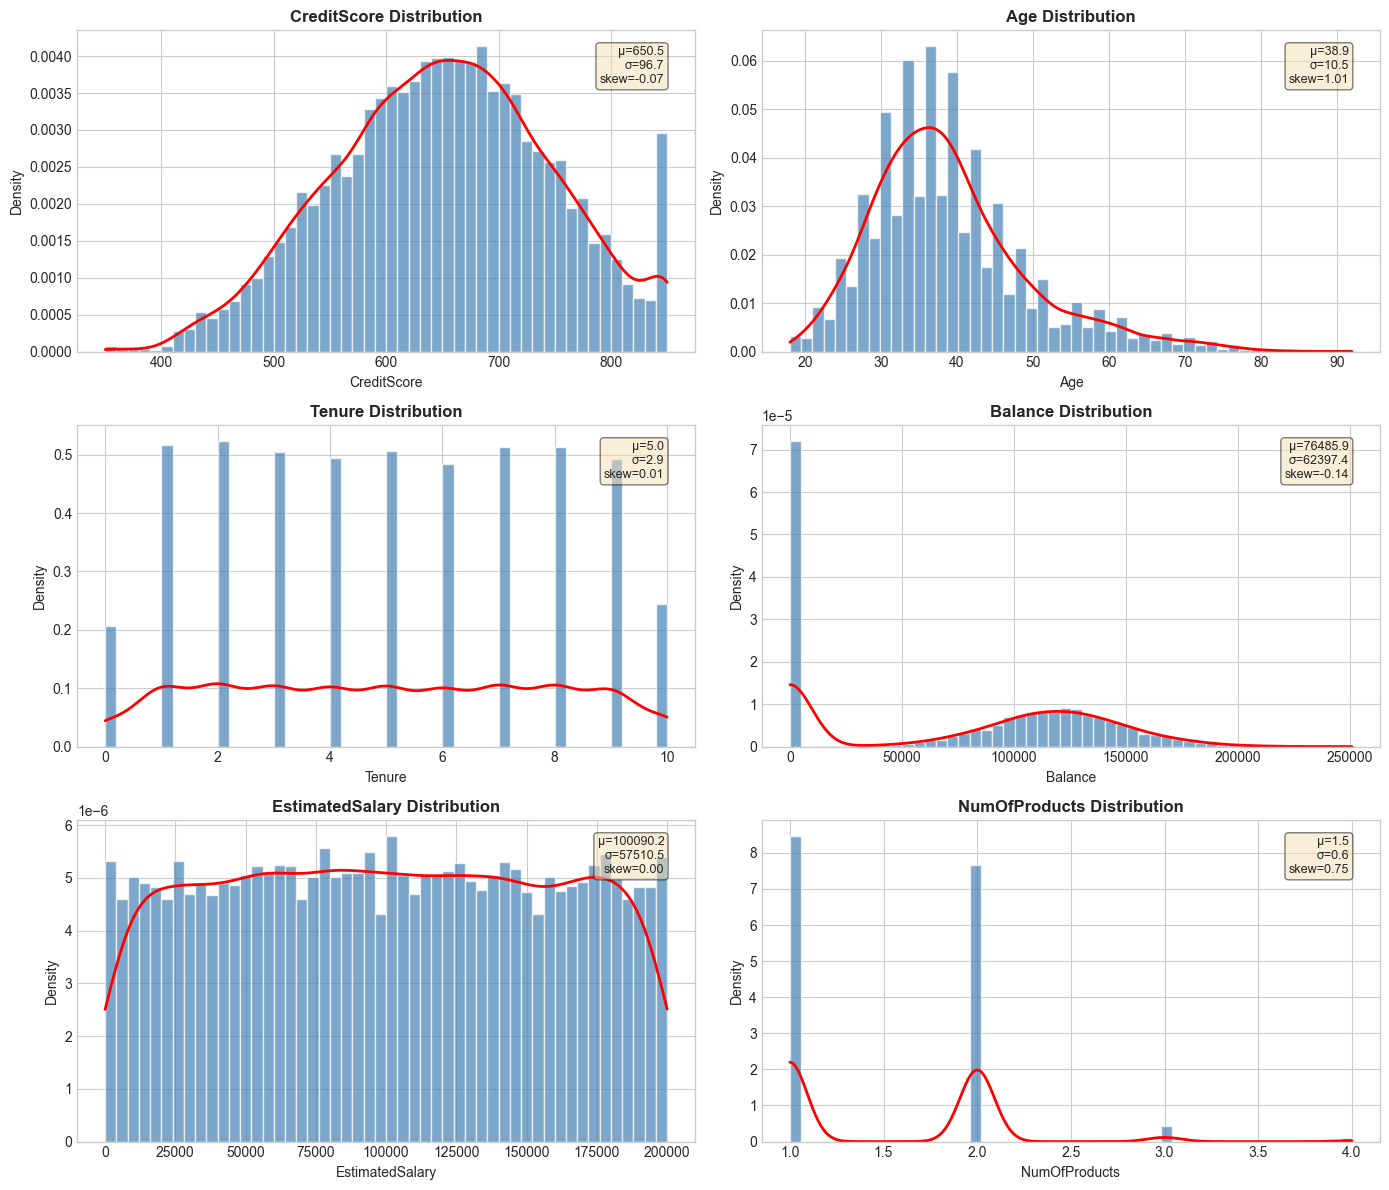

In [74]:
fig,axes = plt.subplots(3,2,figsize=(14,12))
axes = axes.flatten()

for idx,col in enumerate(numerical_cols):
    ax = axes[idx]

    # Histogram with KDE
    data=df[col]
    ax.hist(data, bins=50, density=True,alpha=0.7, color='steelblue', edgecolor='white')
    ax.set_title(f'{col} Distribution', fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')

    if data.std() > 0:
        kde_x = np.linspace(data.min(), data.max(), 200)
        kde = stats.gaussian_kde(data)
        ax.plot(kde_x, kde(kde_x), 'r-', lw=2, label='KDE')
    
    # Stats annotation
    stats_text = f'μ={data.mean():.1f}\nσ={data.std():.1f}\nskew={data.skew():.2f}'
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()

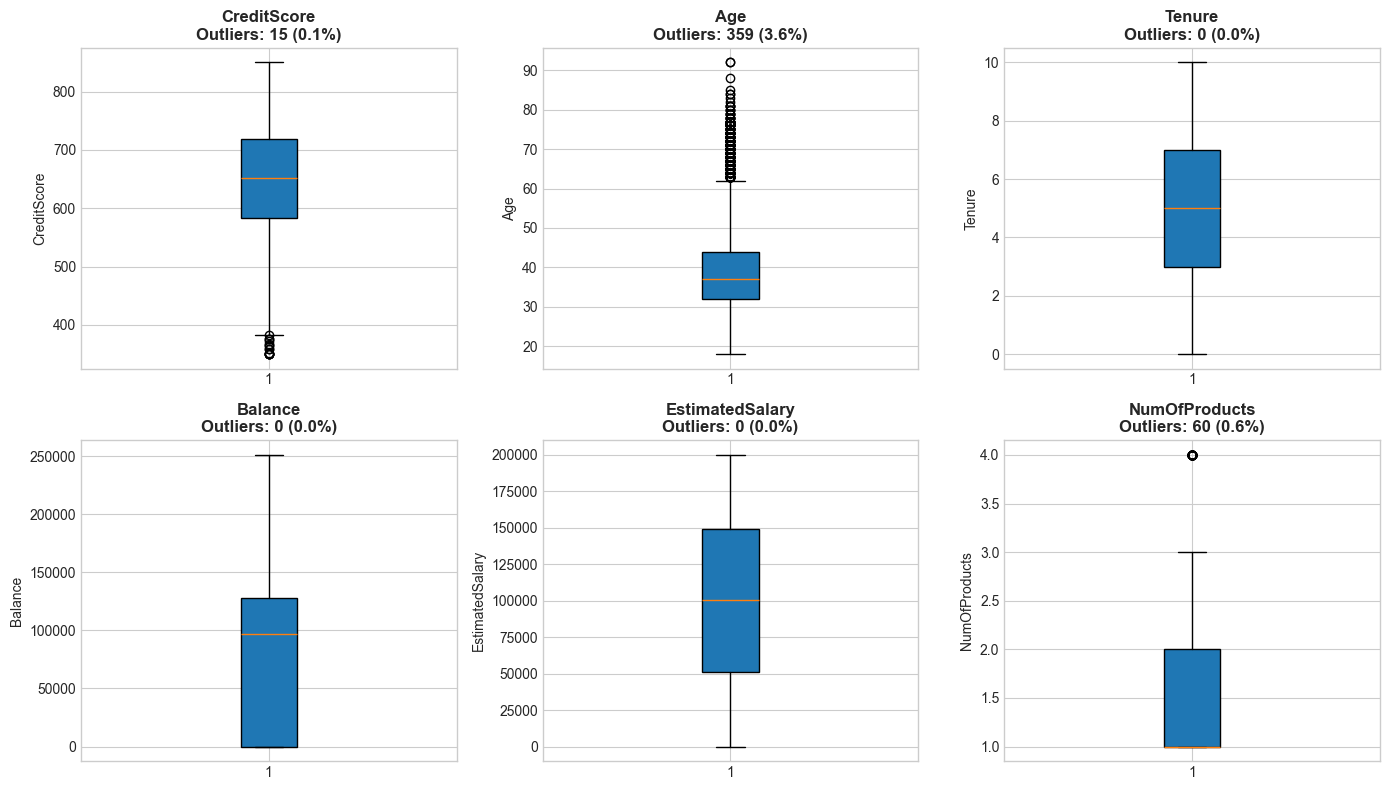

In [79]:
# Box plots for outlier detection
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()
for idx, col in enumerate(numerical_cols):
    ax = axes[idx]
    bp = ax.boxplot(df[col],patch_artist=True)
    Q1,Q3 = df[col].quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_fence = Q1 - (1.5 * IQR)
    upper_fence = Q3 + (1.5 * IQR)
    outliers = ((df[col] < lower_fence) | (df[col] > upper_fence)).sum()
    outlier_pct = outliers / len(df) * 100
    ax.set_title(f'{col}\nOutliers: {outliers} ({outlier_pct:.1f}%)', fontweight='bold')
    ax.set_ylabel(col)
plt.tight_layout()

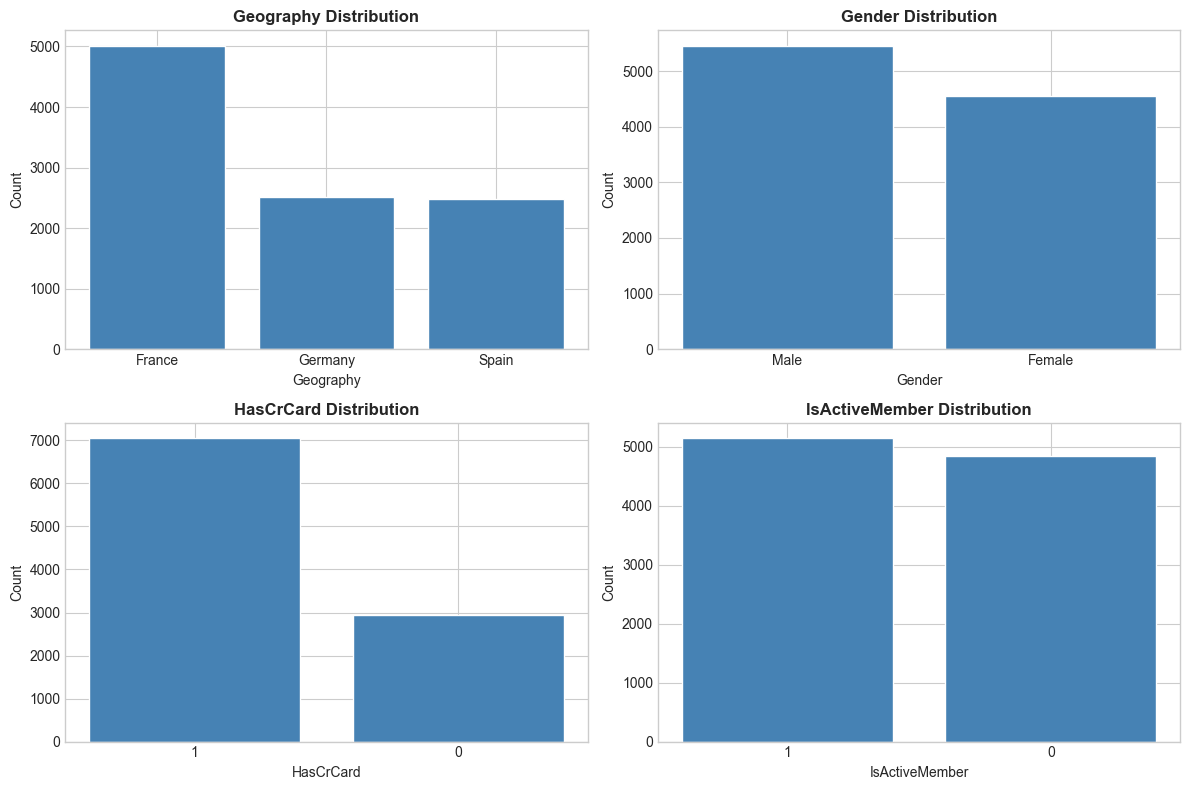

In [81]:
# Categorical distributions 
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols + binary_cols):
    ax = axes[idx]
    counts = df[col].value_counts()
    bars = ax.bar(counts.index.astype(str), counts.values, color='steelblue', edgecolor='white')
    ax.set_title(f'{col} Distribution', fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
plt.tight_layout()

Univariate insights:

1. CreditScore - near-normal distribution, minimal outliers (0.1%), no transformation needed
2. Age - right-skewed with tail of elderly customers (3.6% outliers >62), consider binning or log transform
3. Tenure - uniform distribution (suspicious - possibly synthetic data), no outliers
4. Balance - clear bimodal: 36% at zero + normal distribution for rest. Critical feature engineering opportunity: create HasBalance binary feature
5. EstimatedSalary - perfectly uniform (definitely synthetic), likely low predictive value
6. NumOfProducts - heavily concentrated at 1-2, rare 3-4 (outliers). Consider treating as categorical

In [16]:
# # k2samp interpretaion
# WHY KS-TEST (not t-test)?
# • Doesn't assume normal distribution (non-parametric)
# • Detects ANY difference in distributions (not just means)
# • Works well with skewed data (like Balance, Age)
    
# INTERPRETATION:
# • KS statistic: 0 to 1 (higher = more different)
# • p-value < 0.05: Distributions are significantly different

retained_age = df[df['Exited'] == 0]['EstimatedSalary']
churned_age = df[df['Exited'] == 1]['EstimatedSalary']
ks_stat, ks_pval = stats.ks_2samp(retained_age, churned_age)
print(f"Retained customers: n={len(retained_age)}, mean={retained_age.mean():.1f}, std={retained_age.std():.1f}")
print(f"Churned customers:  n={len(churned_age)}, mean={churned_age.mean():.1f}, std={churned_age.std():.1f}")
print(f"\nKS Statistic: {ks_stat:.4f}")
print(f"p-value: {ks_pval:.2e}")
print(f"\nConclusion: {'SIGNIFICANT - EstimatedSalary distributions ARE different!' if ks_pval < 0.05 else 'Not significant'}")

Retained customers: n=7963, mean=99738.4, std=57405.6
Churned customers:  n=2037, mean=101465.7, std=57912.4

KS Statistic: 0.0235
p-value: 3.25e-01

Conclusion: Not significant


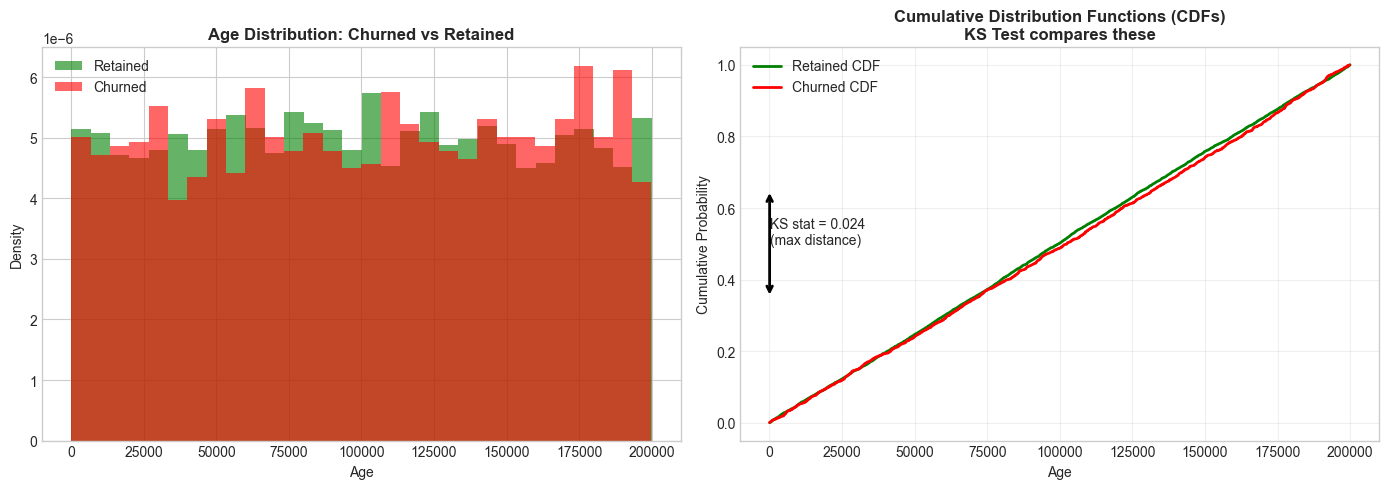

In [17]:
# Visualize KS test
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histograms
ax = axes[0]
ax.hist(retained_age, bins=30, alpha=0.6, density=True, label='Retained', color='green')
ax.hist(churned_age, bins=30, alpha=0.6, density=True, label='Churned', color='red')
ax.set_title('Age Distribution: Churned vs Retained', fontweight='bold')
ax.set_xlabel('Age')
ax.set_ylabel('Density')
ax.legend()
# Right: CDFs (what KS test actually compares)
ax = axes[1]
# Calculate CDFs
retained_sorted = np.sort(retained_age)
churned_sorted = np.sort(churned_age)
retained_cdf = np.arange(1, len(retained_sorted) + 1) / len(retained_sorted)
churned_cdf = np.arange(1, len(churned_sorted) + 1) / len(churned_sorted)

ax.plot(retained_sorted, retained_cdf, label='Retained CDF', color='green', linewidth=2)
ax.plot(churned_sorted, churned_cdf, label='Churned CDF', color='red', linewidth=2)

# Show max distance (KS statistic)
ax.annotate('', xy=(50, 0.65), xytext=(50, 0.35),
            arrowprops=dict(arrowstyle='<->', color='black', lw=2))
ax.text(52, 0.5, f'KS stat = {ks_stat:.3f}\n(max distance)', fontsize=10)

ax.set_title('Cumulative Distribution Functions (CDFs)\nKS Test compares these', fontweight='bold')
ax.set_xlabel('Age')
ax.set_ylabel('Cumulative Probability')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

In [11]:
features_to_test = ['Age', 'Balance', 'CreditScore', 'Tenure', 'EstimatedSalary']
print(f"{'Feature':<18} {'KS Statistic':>12} {'p-value':>12} {'Significant?':>14}")
print("-" * 60)

for feat in features_to_test:
    retained = df[df['Exited'] == 0][feat]
    churned = df[df['Exited'] == 1][feat]
    ks_stat, ks_pval = stats.ks_2samp(retained, churned)
    sig = "YES ***" if ks_pval < 0.001 else "YES **" if ks_pval < 0.01 else "YES *" if ks_pval < 0.05 else "NO"
    print(f"{feat:<18} {ks_stat:>12.4f} {ks_pval:>12.2e} {sig:>14}")

Feature            KS Statistic      p-value   Significant?
------------------------------------------------------------
Age                      0.3866    2.12e-217        YES ***
Balance                  0.1495     4.46e-32        YES ***
CreditScore              0.0358     3.01e-02          YES *
Tenure                   0.0198     5.43e-01             NO
EstimatedSalary          0.0235     3.25e-01             NO


In [82]:
print("PHASE 3: BIVARIATE ANALYSIS (Features vs Target)")

PHASE 3: BIVARIATE ANALYSIS (Features vs Target)


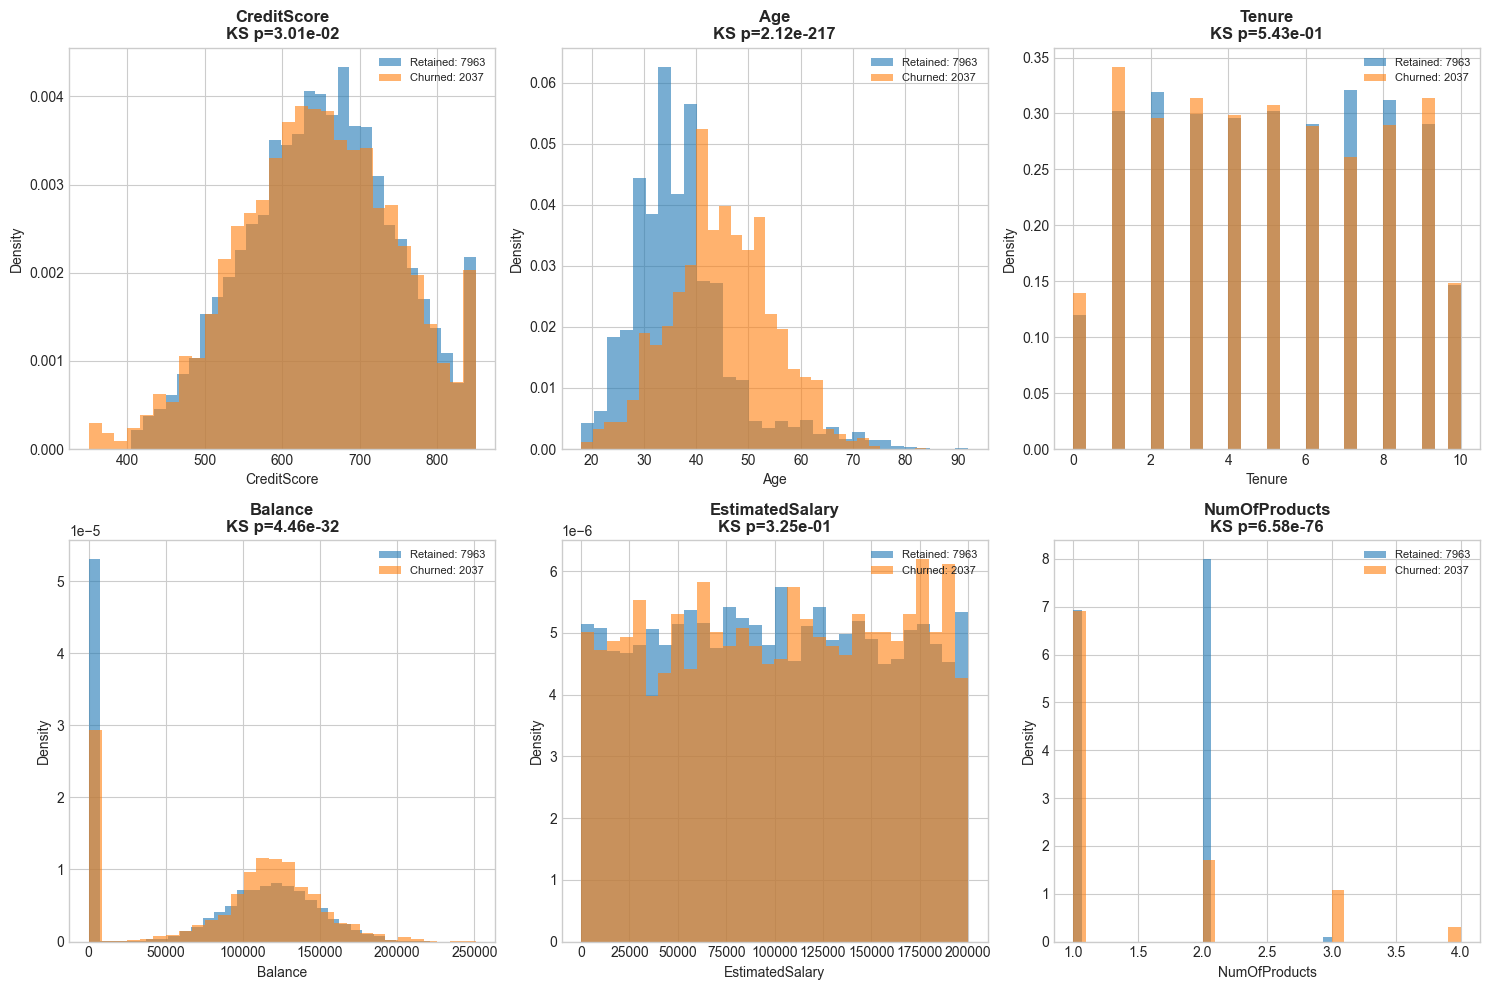

In [96]:
# 3.1 Numerical features vs Target - distributions comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
churn_rate_by_feature = {}

for idx, col in enumerate(numerical_cols):
    ax = axes[idx]
    retained = df[df['Exited']==0][col]
    churned = df[df['Exited']==1][col]
    ax.hist(retained, bins=30, alpha=0.6, label=f'Retained: {len(retained)}', density=True)
    ax.hist(churned, bins=30, alpha=0.6, label=f'Churned: {len(churned)}', density=True)

    # KS test for distribution difference
    ks_stat, ks_pval = stats.ks_2samp(retained, churned)

    
    ax.set_title(f'{col}\nKS p={ks_pval:.2e}', fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)
    ax.set_xlabel(col)
    ax.set_ylabel('Density')
plt.tight_layout()


Chi-Square Statistic: 301.26
Degrees of Freedom: 2
p-value: 3.83e-66

Conclusion: SIGNIFICANT - Geography IS associated with Churn!


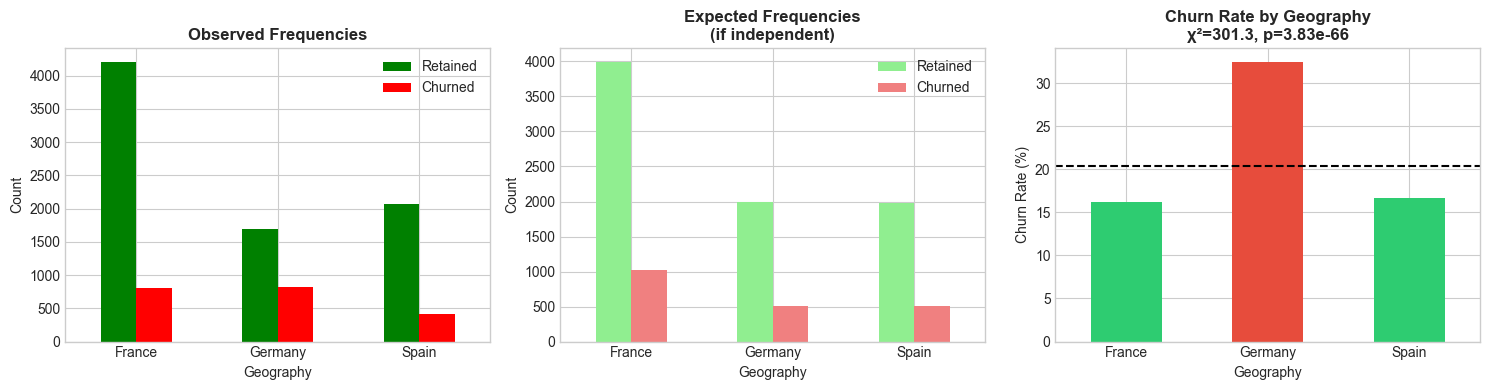

In [26]:
# ChiSquare interpreation(chi2_contingency)
# PURPOSE: Test association between CATEGORICAL feature and target
# FORMULA:
# χ² = Σ (Observed - Expected)² / Expected
# INTERPRETATION:
#  χ² statistic: Higher = stronger association
#  p-value < 0.05: Variables are NOT independent (there IS a relationship)
contingency = pd.crosstab(df['Geography'], df['Exited'])
contingency.columns = ['Retained', 'Churned']
# Perform chi-square test
chi2, p_val, dof, expected = stats.chi2_contingency(contingency)
expected_df = pd.DataFrame(expected, index=contingency.index, columns=contingency.columns)
print(f"\nChi-Square Statistic: {chi2:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"p-value: {p_val:.2e}")
print(f"\nConclusion: {'SIGNIFICANT - Geography IS associated with Churn!' if p_val < 0.05 else 'Not significant'}")
#  Visualize the difference
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Observed
ax = axes[0]
contingency.plot(kind='bar', ax=ax, color=['green', 'red'])
ax.set_title('Observed Frequencies', fontweight='bold')
ax.set_xlabel('Geography')
ax.set_ylabel('Count')
ax.legend(title='')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Expected
ax = axes[1]
expected_df.plot(kind='bar', ax=ax, color=['lightgreen', 'lightcoral'])
ax.set_title('Expected Frequencies\n(if independent)', fontweight='bold')
ax.set_xlabel('Geography')
ax.set_ylabel('Count')
ax.legend(title='')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Churn rates
ax = axes[2]
churn_rates = df.groupby('Geography')['Exited'].mean() * 100
colors = ['#2ecc71' if r < 20 else '#e74c3c' for r in churn_rates]
churn_rates.plot(kind='bar', ax=ax, color=colors)
ax.axhline(20.4, color='black', linestyle='--', label='Baseline (20.4%)')
ax.set_title(f'Churn Rate by Geography\nχ²={chi2:.1f}, p={p_val:.2e}', fontweight='bold')
ax.set_xlabel('Geography')
ax.set_ylabel('Churn Rate (%)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()

In [28]:
cat_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']
print(f"{'Feature':<18} {'χ² Statistic':>12} {'p-value':>12} {'Significant?':>14}")
for feat in cat_features:
    contingency = pd.crosstab(df[feat], df['Exited'])
    chi2, p_val, dof, expected = stats.chi2_contingency(contingency)
    sig = "YES ***" if p_val < 0.001 else "YES **" if p_val < 0.01 else "YES *" if p_val < 0.05 else "NO"
    print(f"{feat:<18} {chi2:>12.2f} {p_val:>12.2e} {sig:>14}")

Feature            χ² Statistic      p-value   Significant?
Geography                301.26     3.83e-66        YES ***
Gender                   112.92     2.25e-26        YES ***
HasCrCard                  0.47     4.92e-01             NO
IsActiveMember           242.99     8.79e-55        YES ***
NumOfProducts           1503.63     0.00e+00        YES ***


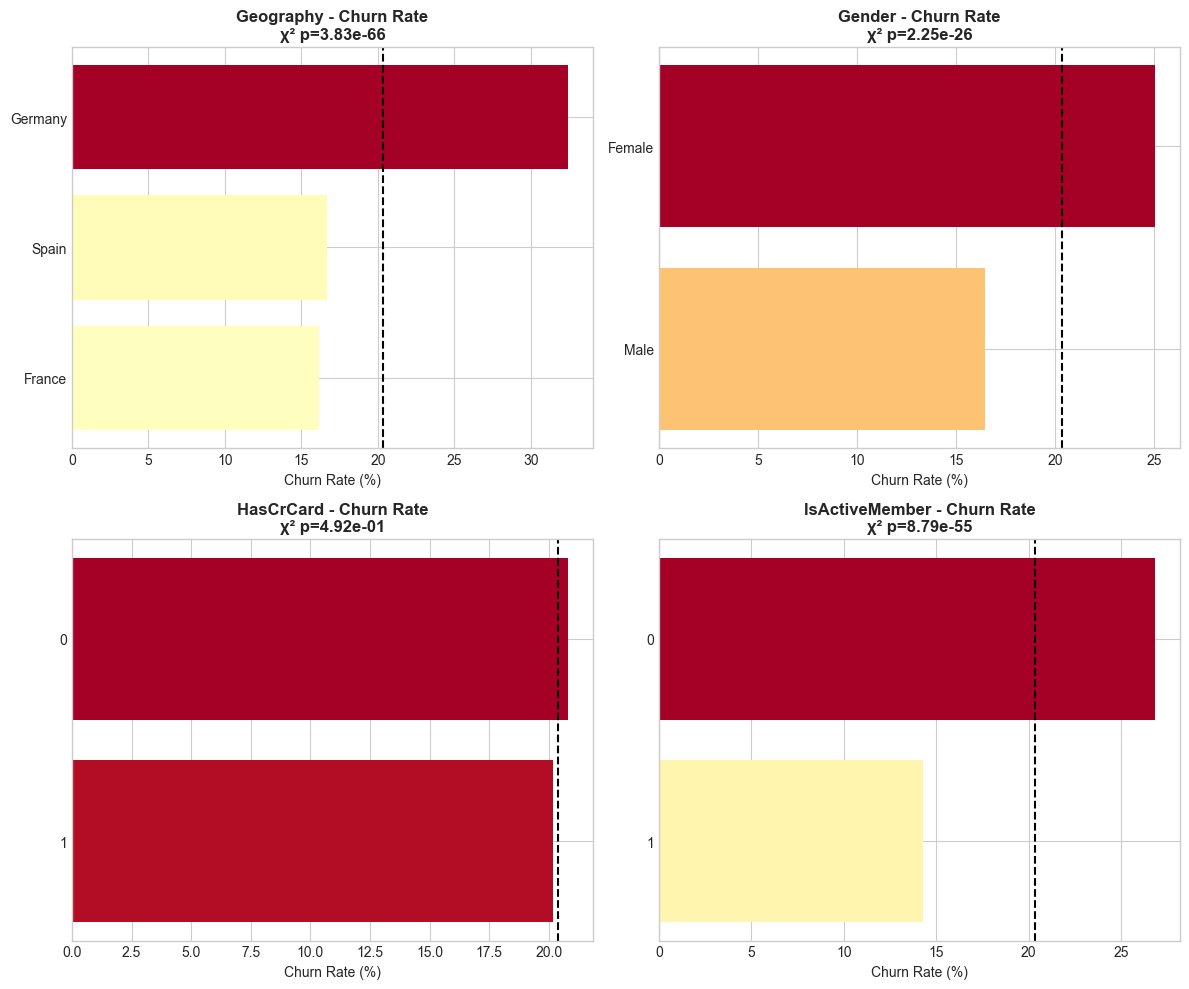

In [108]:
# 3.3 Categorical features vs Target - Churn rates
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

all_cats = categorical_cols + binary_cols
for idx, col in enumerate(all_cats):
    ax = axes[idx]
    churn_by_cat = df.groupby(col)['Exited'].agg(['mean', 'count', 'sum'])
    churn_by_cat.columns = ['ChurnRate', 'Total', 'Churned']
    churn_by_cat = churn_by_cat.sort_values('ChurnRate', ascending=True)
    # Bar plot
    colors = plt.cm.RdYlGn_r(churn_by_cat['ChurnRate'] / churn_by_cat['ChurnRate'].max())
    bars = ax.barh(churn_by_cat.index.astype(str), churn_by_cat['ChurnRate']*100, color=colors)
    # Chi-square test
    contingency = pd.crosstab(df[col], df['Exited'])
    chi2, p_val, dof, expected = stats.chi2_contingency(contingency)

    ax.set_title(f'{col} - Churn Rate\nχ² p={p_val:.2e}', fontweight='bold')
    ax.set_xlabel('Churn Rate (%)')
    ax.axvline(df['Exited'].mean()*100, color='black', linestyle='--', label='Overall')
plt.tight_layout()

In [122]:
# 3.4 Detailed churn rate analysis  
all_cats = categorical_cols + binary_cols
for col in all_cats:
    print(f"\n{col}:")
    churn_by_cat = df.groupby(col)['Exited'].agg(['mean', 'count'])
    for idx_val, row in churn_by_cat.iterrows():
        print(f"  {idx_val}: {row['mean']*100:.1f}% churn (n={int(row['count']):,})")

    # Chi-square
    contingency = pd.crosstab(df[col], df['Exited'])
    chi2, p_val, dof, expected = stats.chi2_contingency(contingency)
    print(f"  Chi-square p-value: {p_val:.2e}")


Geography:
  France: 16.2% churn (n=5,014)
  Germany: 32.4% churn (n=2,509)
  Spain: 16.7% churn (n=2,477)
  Chi-square p-value: 3.83e-66

Gender:
  Female: 25.1% churn (n=4,543)
  Male: 16.5% churn (n=5,457)
  Chi-square p-value: 2.25e-26

HasCrCard:
  0: 20.8% churn (n=2,945)
  1: 20.2% churn (n=7,055)
  Chi-square p-value: 4.92e-01

IsActiveMember:
  0: 26.9% churn (n=4,849)
  1: 14.3% churn (n=5,151)
  Chi-square p-value: 8.79e-55


In [121]:
for idx, row in df.groupby('Geography')['Exited'].agg(['mean', 'count']).iterrows():
    print(f" {idx}: {row['mean']*100:.1f}% churn (n={int(row['count']):,})")

 France: 16.2% churn (n=5,014)
 Germany: 32.4% churn (n=2,509)
 Spain: 16.7% churn (n=2,477)


In [ ]:
# PROBLEM WITH P-VALUES:
#     • With large samples, even TINY differences become "significant"
#     • p-value tells you IF there's a difference, not HOW BIG
#     • A feature can be statistically significant but practically useless
    
# SOLUTION: EFFECT SIZE METRICS

# For Numerical Features → Cohen's d
#     d = (mean₁ - mean₂) / pooled_std
    
#     Interpretation:
#     • |d| < 0.2  → Negligible effect (probably useless)
#     • |d| 0.2-0.5 → Small effect
#     • |d| 0.5-0.8 → Medium effect  
#     • |d| > 0.8  → Large effect (definitely useful!)

# For Categorical Features → Cramér's V
#     V = √(χ² / (n × (min(rows, cols) - 1)))
    
#     Interpretation:
#     • V < 0.1  → Negligible
#     • V 0.1-0.3 → Small
#     • V 0.3-0.5 → Medium
#     • V > 0.5  → Large
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group2.mean() - group1.mean()) / pooled_std


numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
print(f"{'Feature':<18} {'Cohens d':>12} {'Effect Size':>14} {'Useful?':>10}")
print("-" * 60)

for feat in numerical_features:
    retained = df[df['Exited'] == 0][feat]
    churned = df[df['Exited'] == 1][feat]
    d = cohens_d(retained, churned)

    if abs(d) < 0.2:
        effect = "Negligible"
        useful = "NO"
    elif abs(d) < 0.5:
        effect = "Small"
        useful = "Maybe"
    elif abs(d) < 0.8:
        effect = "Medium"
        useful = "YES"
    else:
        effect = "Large"
        useful = "YES!"

    print(f"{feat:<18} {d:>12.3f} {effect:>14} {useful:>10}")

Feature                Cohens d    Effect Size    Useful?
------------------------------------------------------------
CreditScore              -0.067     Negligible         NO
Age                       0.739         Medium        YES
Tenure                   -0.035     Negligible         NO
Balance                   0.296          Small      Maybe
EstimatedSalary           0.030     Negligible         NO


In [ ]:
# 3.5 NumOfProducts deep dive
prod_analysis = df.groupby('NumOfProducts').agg({
    'Exited': ['mean', 'count'],
    'Balance': 'mean',
    'Age': 'mean'
}).round(2)
prod_analysis.columns = ['ChurnRate', 'Count', 'AvgBalance', 'AvgAge']
print(prod_analysis)

               ChurnRate  Count  AvgBalance  AvgAge
NumOfProducts                                      
1                   0.28   5084    98551.87   39.67
2                   0.08   4590    51879.15   37.75
3                   0.83    266    75458.33   43.20
4                   1.00     60    93733.14   45.68


In [126]:
# 3.6 Balance zero vs non-zero impact

df['HasBalance'] = (df['Balance'] > 0).astype(int)
balance_impact = df.groupby('HasBalance')['Exited'].agg(['mean', 'count'])
balance_impact.columns = ['ChurnRate', 'Count']
balance_impact.index = ['Zero Balance', 'Has Balance']
print(balance_impact)

              ChurnRate  Count
Zero Balance   0.138236   3617
Has Balance    0.240796   6383


In [129]:
print("PHASE 4: MULTIVARIATE ANALYSIS")

PHASE 4: MULTIVARIATE ANALYSIS


Strong predictors (for feature engineering):

1. Age - Cohen's d = 0.74 (large effect). Churners are ~7 years older on average. Clear segmentation opportunity.
2. Geography - Germany has 2x churn rate (32.4%) vs France/Spain (~16%). Must be one-hot encoded or target-encoded.
3. Gender - Females churn 52% more than males (25.1% vs 16.5%). Significant.
4. IsActiveMember - Inactive members churn 1.9x more (26.9% vs 14.3%). Key engagement metric.
5.NumOfProducts - Non-linear! 2 products = 8% churn (best), 3-4 = 83-100% churn (extreme risk). This needs careful handling - possibly polynomial or binned features.

Weak/No predictors (consider dropping or interaction features only):

1. Tenure - No significant difference (p=0.54), Cohen's d near zero
2. CreditScore - Marginally significant, tiny effect (d=-0.07)
3. EstimatedSalary - No predictive value (p=0.32), likely synthetic noise
4. HasCrCard - Not significant (p=0.49)

In [131]:
# 4.1 Correlation matrix (numerical features + target)
corr_cols = numerical_cols + ['Exited']
corr_matrix = df[corr_cols].corr()
corr_matrix

,CreditScore,Age,Tenure,Balance,EstimatedSalary,NumOfProducts,Exited
CreditScore,1.000000,-0.003965,0.000842,0.006268,-0.001384,0.012238,-0.027094
Age,-0.003965,1.000000,-0.009997,0.028308,-0.007201,-0.030680,0.285323
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.007784,0.013444,-0.014001
Balance,0.006268,0.028308,-0.012254,1.000000,0.012797,-0.304180,0.118533
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,1.000000,0.014204,0.012097
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,0.014204,1.000000,-0.047820
Exited,-0.027094,0.285323,-0.014001,0.118533,0.012097,-0.047820,1.000000


In [134]:
np.triu(np.ones_like(corr_matrix, dtype=bool))

array([[ True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True],
       [False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False,  True]])

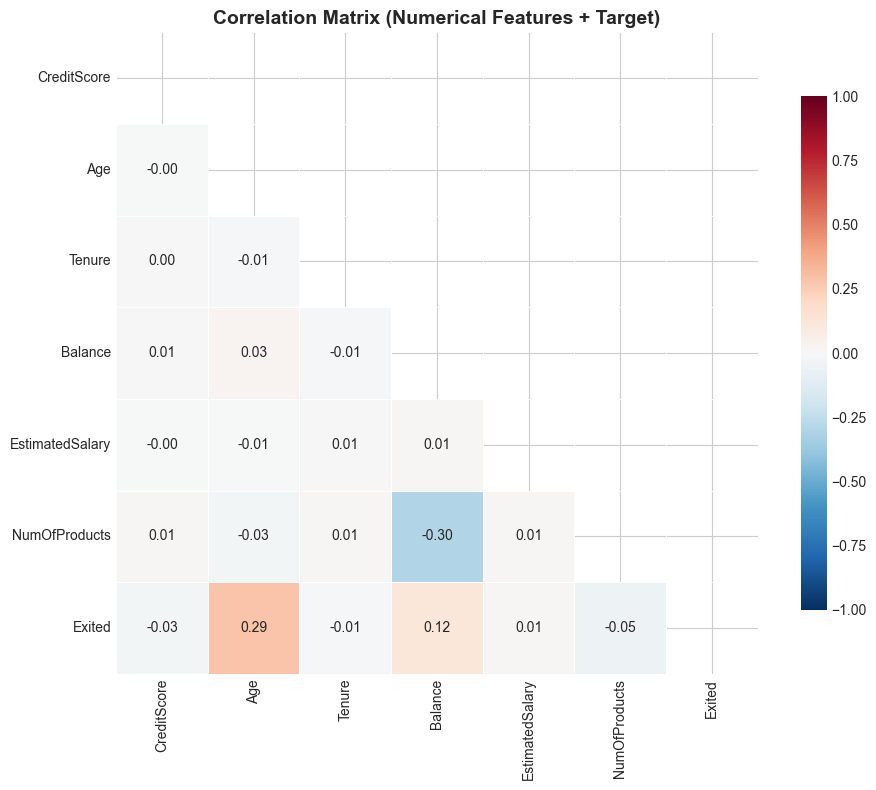

In [132]:
fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True, linewidths=0.5,
            cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix (Numerical Features + Target)', fontweight='bold', fontsize=14)
plt.tight_layout()

In [137]:
# 4.2 Feature correlations with target
target_corr = corr_matrix['Exited'].drop('Exited').sort_values(key=abs, ascending=False)
for feat, corr in target_corr.items():
    bar = '-->' * int(abs(corr) * 50)
    sign = '+' if corr > 0 else '-'
    print(f"  {feat:<18} {sign}{abs(corr):.3f} {bar}")

  Age                +0.285 -->-->-->-->-->-->-->-->-->-->-->-->-->-->
  Balance            +0.119 -->-->-->-->-->
  NumOfProducts      -0.048 -->-->
  CreditScore        -0.027 -->
  Tenure             -0.014 
  EstimatedSalary    +0.012 


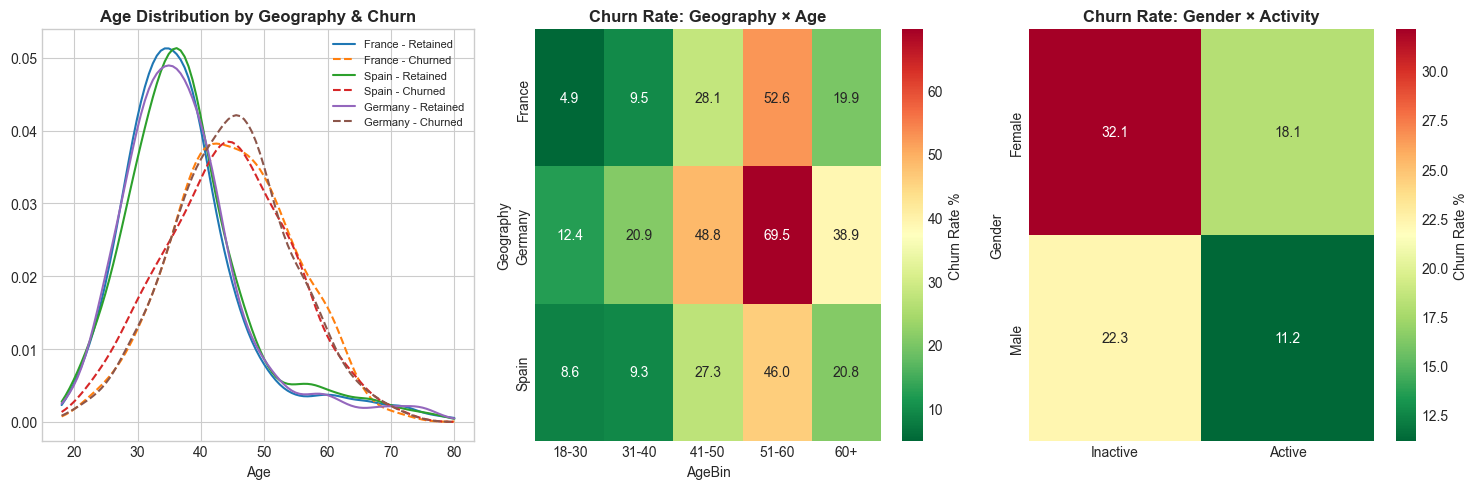

In [139]:
# 4.3 Key interaction: Age × Geography × Gender
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Age distribution by Geography and Churn
ax = axes[0]
for geo in df['Geography'].unique():
    for exited in [0, 1]:
        subset = df[(df['Geography'] == geo) & (df['Exited'] == exited)]['Age']
        label = f"{geo} - {'Churned' if exited else 'Retained'}"
        linestyle = '--' if exited else '-'
        kde = stats.gaussian_kde(subset)
        x = np.linspace(18, 80, 100)
        ax.plot(x, kde(x), label=label, linestyle=linestyle)
ax.set_title('Age Distribution by Geography & Churn', fontweight='bold')
ax.legend(fontsize=8)
ax.set_xlabel('Age')

# Churn rate heatmap: Geography × Age bins
ax = axes[1]
df['AgeBin'] = pd.cut(df['Age'], bins=[0, 30, 40, 50, 60, 100],
                      labels=['18-30', '31-40', '41-50', '51-60', '60+'])
pivot = df.pivot_table(values='Exited', index='Geography', columns='AgeBin', aggfunc='mean')
sns.heatmap(pivot*100, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax,
            cbar_kws={'label': 'Churn Rate %'})
ax.set_title('Churn Rate: Geography × Age', fontweight='bold')

# Gender × IsActiveMember interaction
ax = axes[2]
pivot2 = df.pivot_table(values='Exited', index='Gender', columns='IsActiveMember', aggfunc='mean')
pivot2.columns = ['Inactive', 'Active']
sns.heatmap(pivot2*100, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax,
            cbar_kws={'label': 'Churn Rate %'})
ax.set_title('Churn Rate: Gender × Activity', fontweight='bold')

plt.tight_layout()


In [142]:
df.pivot_table(values='Exited', index='NumOfProducts', columns='Geography', aggfunc='mean')

Geography,France,Germany,Spain
NumOfProducts,,,
1,0.224344,0.428466,0.218673
2,0.057034,0.121154,0.073542
3,0.788462,0.895833,0.787879
4,1.000000,1.000000,1.000000


In [145]:
df[df['NumOfProducts']==4]['Exited'].value_counts()

Exited
1    60
Name: count, dtype: int64

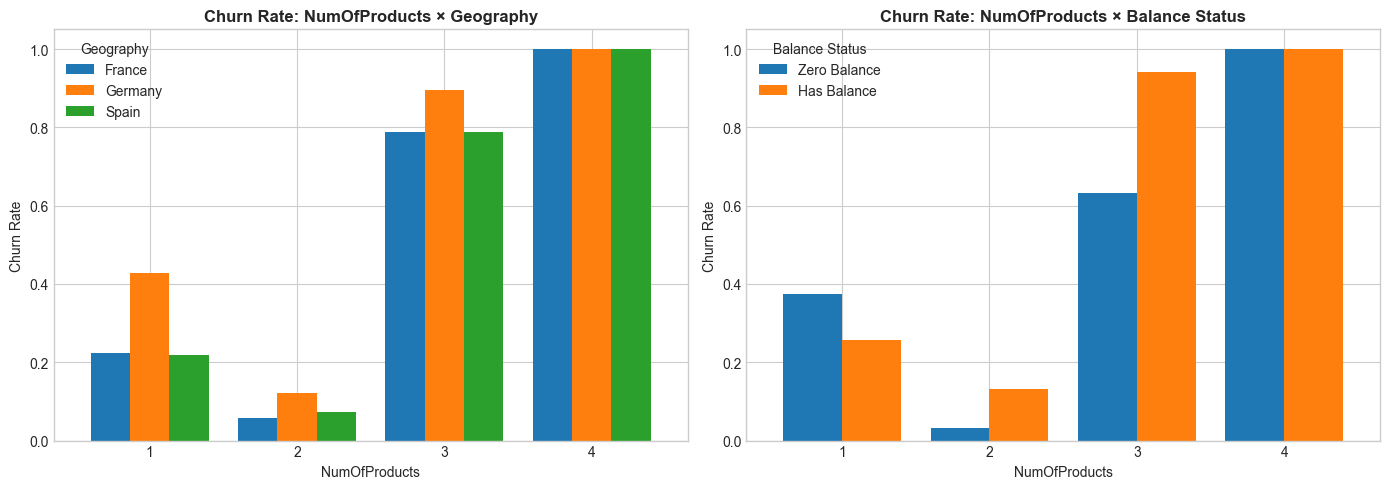

In [ ]:
#  4.4 NumOfProducts interaction analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Products × Geography
ax = axes[0]
pivot3 = df.pivot_table(values='Exited', index='NumOfProducts', columns='Geography', aggfunc='mean')
pivot3.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Churn Rate: NumOfProducts × Geography', fontweight='bold')
ax.set_ylabel('Churn Rate')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='Geography')

# Products × Balance (zero vs non-zero)
ax = axes[1]
pivot4 = df.pivot_table(values='Exited', index='NumOfProducts', columns='HasBalance', aggfunc='mean')
pivot4.columns = ['Zero Balance', 'Has Balance']
pivot4.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Churn Rate: NumOfProducts × Balance Status', fontweight='bold')
ax.set_ylabel('Churn Rate')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='Balance Status')

plt.tight_layout()


In [149]:
# Create risk segments
segments = [
    ("Germany + Female + Inactive",
     (df['Geography'] == 'Germany') & (df['Gender'] == 'Female') & (df['IsActiveMember'] == 0)),
    ("Germany + Age>50",
     (df['Geography'] == 'Germany') & (df['Age'] > 50)),
    ("NumOfProducts >= 3",
     df['NumOfProducts'] >= 3),
    ("Germany + Female + NumOfProducts=1",
     (df['Geography'] == 'Germany') & (df['Gender'] == 'Female') & (df['NumOfProducts'] == 1)),
    ("Age>50 + Inactive",
     (df['Age'] > 50) & (df['IsActiveMember'] == 0)),
]

print(f"{'Segment':<40} {'Count':>8} {'Churn%':>8} {'Lift':>8}")
print("-" * 64)
baseline = df['Exited'].mean()
for name, mask in segments:
    subset = df[mask]
    churn_rate = subset['Exited'].mean()
    lift = churn_rate / baseline
    print(f"{name:<40} {len(subset):>8,} {churn_rate*100:>7.1f}% {lift:>7.2f}x")

# 4.6 Feature interactions for modeling
print("\n Suggested Interaction Features:")
print("-" * 50)
print("  1. Age × Geography (Germany aging population high risk)")
print("  2. Gender × IsActiveMember")
print("  3. NumOfProducts (treat as categorical, or polynomial)")
print("  4. HasBalance (binary from Balance)")
print("  5. Age × IsActiveMember")
print("  6. Germany_Female interaction flag")

# Clean up temp column
# df = df.drop('AgeBin', axis=1)

Segment                                     Count   Churn%     Lift
----------------------------------------------------------------
Germany + Female + Inactive                   634    44.6%    2.19x
Germany + Age>50                              356    59.8%    2.94x
NumOfProducts >= 3                            326    85.9%    4.22x
Germany + Female + NumOfProducts=1            664    47.1%    2.31x
Age>50 + Inactive                             425    84.9%    4.17x

 Suggested Interaction Features:
--------------------------------------------------
  1. Age × Geography (Germany aging population high risk)
  2. Gender × IsActiveMember
  3. NumOfProducts (treat as categorical, or polynomial)
  4. HasBalance (binary from Balance)
  5. Age × IsActiveMember
  6. Germany_Female interaction flag


# EDA EXECUTIVE SUMMARY    

#### Dataset: 10,000 bank customers, 14 features, binary classification (churn)
#### Target: 20.4% churn rate (moderate imbalance, 3.9:1 ratio)
#### Data Quality: No nulls, no duplicates, clean (possibly synthetic)

1. AGE (Cohen's d = 0.74)
- Non-linear: 51-60 age group has 2-3x higher churn
- FEATURE ENG: Age bins, Age² polynomial, Age>50 flag

2. NUM_OF_PRODUCTS(Non-linear)
- 1 product: 28% churn
- 2 products: 8% churn (sweet spot)
- 3+ products: 83-100% churn (exit signal?)
- FEATURE ENG: One-hot encode, or binary "HasMultipleProducts", 
                    "Has3PlusProducts" flag

3. GEOGRAPHY
- Germany: 32.4% churn (2x baseline)
- France/Spain: ~16% (similar)
- FEATURE ENG: One-hot, or binary "IsGermany" flag

4. InActive
- Inactive: 26.9% churn
- Active: 14.3% churn (1.9x difference)
- USE AS-IS

5. Gender
- Female: 25.1% churn
- Male: 16.5% churn
- FEATURE ENG: Binary encode, One-hot encode

6. BALANCE 
- 36% have zero balance (lower churn at 13.8%)
- Non-zero: 24% churn
- Bimodal distribution
- FEATURE ENG: "HasBalance" binary, Balance buckets if non-zero

7. LOW/NO PREDICTIVE VALUE (consider dropping):
- TENURE: No significant difference (p=0.54)
- ESTIMATED_SALARY: Uniform distribution, no signal (p=0.32)
- HAS_CR_CARD: Not significant (p=0.49)
- CREDIT_SCORE: Marginal effect only (d=-0.07)

8. HIGH-RISK SEGMENTS IDENTIFIED:
Segment                               Churn Rate    Lift vs Baseline
--------------------------------------------------------------------
  NumOfProducts >= 3                       85.9%         4.22x
  Age > 50 + Inactive                      84.9%         4.17x
  Germany + Age > 50                       59.8%         2.94x
  Germany + Female + NumOfProducts=1       47.1%         2.31x
  Germany + Female + Inactive              44.6%         2.19x

RECOMMENDED FEATURE ENGINEERING PIPELINE:
1. DROP: RowNumber, CustomerId, Surname, Tenure, EstimatedSalary, HasCrCard

2. BINARY FLAGS:
- HasBalance = (Balance > 0)
- IsGermany = (Geography == 'Germany')
- IsSenior = (Age > 50)
- Has3PlusProducts = (NumOfProducts >= 3)

3. INTERACTIONS:
- Germany_Female = IsGermany * IsFemale
- Senior_Inactive = IsSenior * (1 - IsActiveMember)
- Germany_Senior = IsGermany * IsSenior

4. TRANSFORMATIONS:
- Age: Standard scale + polynomial (Age²) OR bins
- Balance: Log transform for non-zero, or standard scale
- NumOfProducts: One-hot encode (treat as categorical)
- Geography: One-hot encode
- Gender: Binary encode

5. OPTIONAL ADVANCED:
- Target encoding for Geography (with regularization)
- BalancePerProduct = Balance / NumOfProducts
- CreditScore bins (though low value)

MODELING CONSIDERATIONS:

- Class imbalance: Use class_weight='balanced' or SMOTE
- Tree-based models may capture interactions automatically
- For linear models, explicit interactions needed
- NumOfProducts 3-4 segment is tiny (326 samples) - watch for overfitting

<!-- RECOMMENDED FEATURE ENGINEERING PIPELINE: -->